In [491]:
# main.py

import torch
# import data_handler
# import networks
# import trainer
# import utils

import os, time
import scipy.io as sio
from torch.optim import lr_scheduler


# Arguments  ====================================== 반영

dataset = '2020_LER_20200804_V006.xlsx' #2020_LER_20200529_V004.xlsx
datatype = 'n'
mean_model_type = 'mlp'
gan_model_type = 'gan1'
seed = 0
mean_lr = 5e-5
g_lr = 0.0001
d_lr = 0.0005
noise_d = 100
mean_hidden_dim = 100
gan_hidden_dim = 100
batch_size = 32
mean_nepochs = 1000
gan_nepochs = 200
workers = 0
num_of_input = 4
num_of_output = 6
sample_num = 50

# =====================================================

log_name = 'date_20200815_datatype_{}_model_{}_{}_seed_{}_mean_lr_{}_g_lr_{}_d_lr_{}_mean_hidden_dim_{}_gan_type_{}_gan_hidden_dim_{}_batch_{}_epoch_{}_noise_{}'.format(
    datatype,
    mean_model_type,
    gan_model_type,
    seed,
    mean_lr,
    g_lr,
    d_lr,
    mean_hidden_dim,
    gan_model_type, 
    gan_hidden_dim,
    batch_size, 
    mean_nepochs,
    noise_d
)

print(log_name)

# Dataset

dataset = get_dataset(dataset, datatype)

# loss result

result_dict = {}

kwargs = {'num_workers': workers}

print(torch.cuda.device_count())
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    
print("Inits...")
torch.set_default_tensor_type('torch.cuda.FloatTensor')


# ==================================================================================================
#                                          1. Predict mean 
# ==================================================================================================

mean_train_dataset_loader = SemiLoader(dataset.train_X_per_cycle, dataset.train_Y_per_cycle, normalize)
print("dddd", mean_train_dataset_loader.data_y_mean)
mean_val_dataset_loader = SemiLoader(dataset.val_X_per_cycle, dataset.val_Y_per_cycle, normalize)

mean_test_dataset_loader = SemiLoader(dataset.test_X_per_cycle, dataset.test_Y_per_cycle, normalize)

# Dataloader

mean_train_iterator = torch.utils.data.DataLoader(mean_train_dataset_loader, batch_size=batch_size, shuffle=True, **kwargs)

mean_val_iterator = torch.utils.data.DataLoader(mean_val_dataset_loader, batch_size=batch_size, shuffle=True, **kwargs)

mean_test_iterator = torch.utils.data.DataLoader(mean_test_dataset_loader, batch_size=1, shuffle=False, **kwargs)

# model

mean_model = get_mean_model(mean_model_type, mean_hidden_dim, num_of_input, num_of_output, datatype)
mean_model.apply(init_normal)
mean_model.cuda()

print(mean_model)

optimizer = torch.optim.Adam(mean_model.parameters(), lr=mean_lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5) # scheduler

mean_mytrainer = get_mean_trainer(mean_train_iterator, mean_val_iterator, mean_model, mean_model_type, optimizer, exp_lr_scheduler)

for epoch in range(mean_nepochs):
    
    train_loss = mean_mytrainer.train()
    
    val_loss, val_r2 = mean_mytrainer.evaluate()
    
    current_lr = mean_mytrainer.current_lr
    
    if((epoch+1)% 10 == 0):
        print("epoch:{:2d}, lr:{:.6f}, || train_loss:{:.6f}, val_loss:{:.6f}, r2_score:{:.6f}".format(epoch, current_lr, train_loss, val_loss, val_r2))

print("dddd", mean_train_dataset_loader.data_y_mean)

result_dict['train_loss'] = mean_mytrainer.loss['train_loss']
result_dict['val_loss'] = mean_mytrainer.loss['val_loss']
        
mean_best_model = mean_mytrainer.best_model

date_20200815_datatype_n_model_mlp_gan1_seed_0_mean_lr_5e-05_g_lr_0.0001_d_lr_0.0005_mean_hidden_dim_100_gan_type_gan1_gan_hidden_dim_100_batch_32_epoch_1000_noise_100
============ Data load =============
X data shape:  (10000, 5) X per cycle data shape: (200, 5)
Y data shape:  (10000, 6) Y per cycle data shape: (200, 6)
any nan in X?:  []
any nan in Y?:  [[4450    0]
 [4450    1]
 [4450    2]
 ...
 [9999    3]
 [9999    4]
 [9999    5]]
Same number of x data and y data
============= Data split ==============
train X: (3750, 5) train Y: (3750, 6)
val X: (500, 5) val Y: (500, 6)
test X: (750, 5) test Y: (750, 6)
x mean, std:  [  0.41795138  51.47284    122.14498      1.           0.        ] [ 0.20212363 27.062914   51.619465    0.          0.        ]
y mean, std:  [2.2068280e-12 4.1595627e-05 1.6299980e-05 3.4310421e-01 3.5104963e-01
 6.1669216e+01] [7.7416974e-13 2.1877843e-06 8.3063077e-07 7.4241282e-03 6.6630146e-03
 3.2903570e-01]
Same number of x data and y data
============= Dat

epoch: 9, lr:0.000050, || train_loss:0.101888, val_loss:0.227652, r2_score:-1.276524
epoch:19, lr:0.000050, || train_loss:0.067448, val_loss:0.154622, r2_score:-0.546220
epoch:29, lr:0.000050, || train_loss:0.050884, val_loss:0.112430, r2_score:-0.124299
epoch:39, lr:0.000050, || train_loss:0.037065, val_loss:0.087084, r2_score:0.129156
epoch:49, lr:0.000050, || train_loss:0.031174, val_loss:0.072501, r2_score:0.274988
epoch:59, lr:0.000050, || train_loss:0.024798, val_loss:0.064082, r2_score:0.359178
epoch:69, lr:0.000050, || train_loss:0.023199, val_loss:0.058378, r2_score:0.416220
epoch:79, lr:0.000050, || train_loss:0.023113, val_loss:0.054080, r2_score:0.459195
epoch:89, lr:0.000050, || train_loss:0.018968, val_loss:0.050673, r2_score:0.493272
epoch:99, lr:0.000050, || train_loss:0.018221, val_loss:0.048016, r2_score:0.519836
epoch:109, lr:0.000025, || train_loss:0.019188, val_loss:0.047026, r2_score:0.529741
epoch:119, lr:0.000025, || train_loss:0.016789, val_loss:0.046194, r2_sc

epoch:989, lr:0.000000, || train_loss:0.012574, val_loss:0.037016, r2_score:0.629840
epoch:999, lr:0.000000, || train_loss:0.013034, val_loss:0.037014, r2_score:0.629857
dddd [2.2068302e-12 4.1595649e-05 1.6299979e-05 3.4310430e-01 3.5105065e-01
 6.1669186e+01]


In [451]:

# ==================================================================================================
#                                          2. Predict noise
# ==================================================================================================

# predict Y_mean

noise_train_dataset_loader = SemiLoader(dataset.train_X, dataset.train_Y_noise, normalize)

noise_val_dataset_loader = SemiLoader(dataset.val_X, dataset.val_Y_noise, normalize)

noise_test_dataset_loader = SemiLoader(dataset.test_X, dataset.test_Y_noise, normalize)

# Dataloader

noise_train_iterator = torch.utils.data.DataLoader(noise_train_dataset_loader, batch_size=batch_size, shuffle=True, **kwargs)

noise_val_iterator = torch.utils.data.DataLoader(noise_val_dataset_loader, batch_size=batch_size, shuffle=True, **kwargs)

noise_test_iterator = torch.utils.data.DataLoader(noise_test_dataset_loader, batch_size=batch_size, shuffle=False, **kwargs)
# batch_size = sample_num

# model

generator, discriminator = get_gan_model(gan_model_type, gan_hidden_dim, noise_d, num_of_input, num_of_output, datatype)
generator.cuda()
discriminator.cuda()

print(generator, discriminator)

## QQQQ
init_params(generator)
init_params(discriminator)

# scheduler

optimizer_g = torch.optim.Adam(generator.parameters(), lr = g_lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = d_lr)

exp_gan_lr_scheduler = lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.5)

# trainer

gan_mytrainer = get_gan_trainer(noise_train_iterator, noise_val_iterator, gan_model_type, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d)

for epoch in range(gan_nepochs):
    
    p_real_train, p_fake_train = gan_mytrainer.train()
    
    p_real_val, p_fake_val = gan_mytrainer.evaluate()
        
    current_d_lr = gan_mytrainer.current_d_lr
    
    if((epoch+1)% 10 == 0):
        print("epoch:{:2d}, lr_d:{:.6f}, || p_real:{:.6f}, p_fake:{:.6f}".format(epoch, current_d_lr, p_real_val, p_fake_val))
        
result_dict['p_real_train'] = gan_mytrainer.prob['p_real_train']
result_dict['p_fake_train'] = gan_mytrainer.prob['p_fake_train']
result_dict['p_real_val'] = gan_mytrainer.prob['p_real_val']
result_dict['p_fake_val'] = gan_mytrainer.prob['p_fake_val']

# print(result_dict['p_real_train'])

if not os.path.exists('./result_loss'):
    os.makedirs('./result_loss')
np.save('./result_loss/'+log_name, result_dict)

# net.state_dict()
if not os.path.exists('./mean_models'):
    os.makedirs('./mean_models')
torch.save(mean_best_model.state_dict(), './mean_models/'+log_name)
if not os.path.exists('./gen_models'):
    os.makedirs('./gen_models')
torch.save(generator.state_dict(), './gen_models/'+log_name)
if not os.path.exists('./dis_models'):
    os.makedirs('./dis_models')
torch.save(discriminator.state_dict(), './dis_models/'+log_name)

# test에 result 뽑아내고 evaltuation 하기


[  0.41795138  51.47284    122.14498   ] [ 0.20212363 27.062914   51.619465  ]
[-1.3227266e-21 -1.9402554e-15 -1.6787757e-15  5.0640664e-12
  1.2968667e-11 -3.6756198e-10] [7.6438031e-13 1.9064815e-06 7.7873705e-07 7.1961805e-03 6.3704513e-03
 3.2303455e-01]
[  0.45589355  59.654743   131.45201   ] [ 0.22741622 25.40458    67.71074   ]
[-2.9273459e-21  6.4801498e-15 -1.7905677e-15 -3.9581212e-12
  4.8894435e-12  1.1473894e-09] [8.3744188e-13 2.0225852e-06 8.5255238e-07 8.1785982e-03 7.3175956e-03
 3.5185337e-01]
[  0.36179695  58.20464    103.92362   ] [ 0.17608012 27.981607   38.066986  ]
[-3.2345365e-21  4.8506384e-15  3.7895613e-16  2.0954759e-11
 -1.4648928e-11 -1.0331471e-09] [5.9409628e-13 1.5126975e-06 6.5309973e-07 5.4815304e-03 4.8479885e-03
 2.6782158e-01]
gen1(
  (fc1): Linear(in_features=105, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
) dis1(
  (fc1): Linear(in_featur

In [489]:
testType = 'gan' # 'fid, scatter plot' 둘다 그리기

t_classifier = EvaluatorFactory.get_evaluator(sample_num, testType)

# mean result

mean_train_mean = mean_train_dataset_loader.data_y_mean
mean_train_std = mean_train_dataset_loader.data_y_std
print(mean_train_mean, mean_train_std)
mean_result, mean_total = t_classifier.mean_sample(mean_best_model, mean_train_mean, mean_train_std, mean_test_iterator)

# noise result

noise_train_mean = noise_train_dataset_loader.data_y_mean
noise_train_std = noise_train_dataset_loader.data_y_std

noise_result, noise_total = t_classifier.noise_sample(mean_result, generator, noise_train_mean, noise_train_std, mean_test_iterator, num_of_input+1, num_of_output, noise_d)

mean_result = np.repeat(mean_result, sample_num, axis=0)
total_result = noise_result + mean_result

if not os.path.exists('./sample_data'):
    os.makedirs('./sample_data')
np.save('./sample_data/'+'total_'+log_name, total_result)
np.save('./sample_data/'+'mean_'+log_name, mean_result)
np.save('./sample_data/'+'std_'+log_name, noise_result)


[2.2068302e-12 4.1595649e-05 1.6299979e-05 3.4310430e-01 3.5105065e-01
 6.1669186e+01] [1.2272477e-13 1.0731878e-06 2.8898947e-07 1.8254621e-03 1.9527496e-03
 6.2557355e-02]
0
tensor([[-0.7268, -1.6167, -0.3595,  1.0000,  0.0000]])
1
1
tensor([[-0.3267,  0.3042, -0.0930,  1.0000,  0.0000]])
1
2
tensor([[ 1.4939, -1.4723,  1.8371,  1.0000,  0.0000]])
1
3
tensor([[ 1.1060,  0.8118, -0.6135,  1.0000,  0.0000]])
1
4
tensor([[-0.6593, -0.1142, -1.3182,  1.0000,  0.0000]])
1
5
tensor([[-1.1330,  1.2678,  1.2730,  1.0000,  0.0000]])
1
6
tensor([[0.0042, 0.7021, 1.5370, 1.0000, 0.0000]])
1
7
tensor([[ 0.8114, -0.3424, -0.9439,  1.0000,  0.0000]])
1
8
tensor([[-1.2229, -0.0382,  0.2546,  1.0000,  0.0000]])
1
9
tensor([[-0.0801,  0.6656,  0.0408,  1.0000,  0.0000]])
1
10
tensor([[-1.4025,  0.8726, -1.1238,  1.0000,  0.0000]])
1
11
tensor([[ 0.4920, -1.6253,  0.3297,  1.0000,  0.0000]])
1
12
tensor([[ 1.1282, -1.1713, -0.9070,  1.0000,  0.0000]])
1
13
tensor([[-1.0492,  1.3653,  1.1004,  1.0000, 

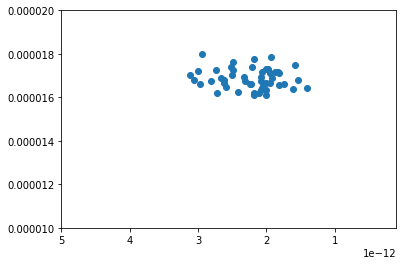

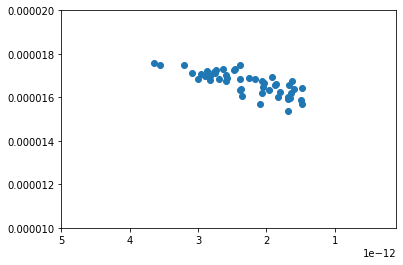

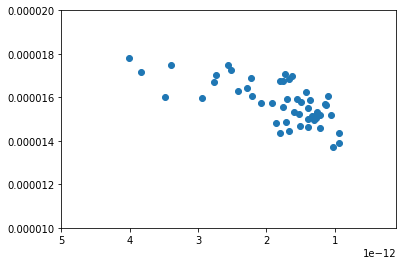

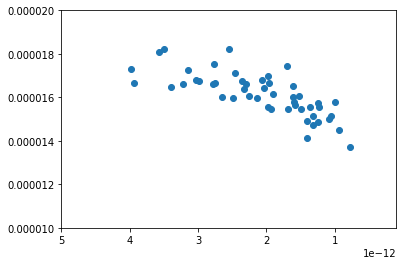

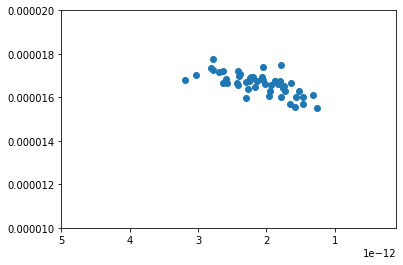

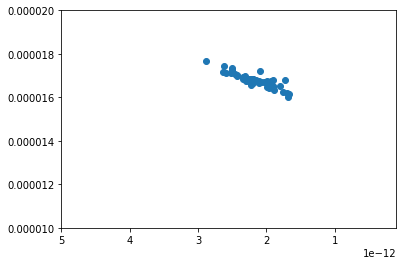

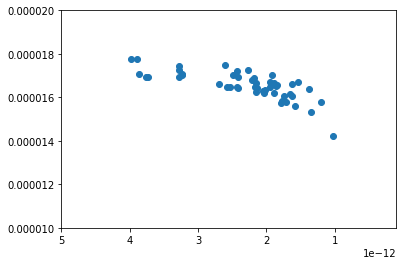

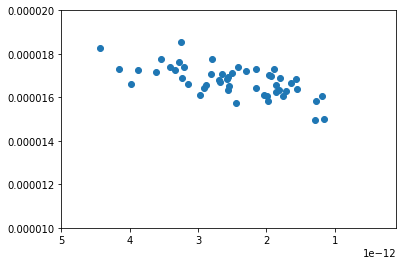

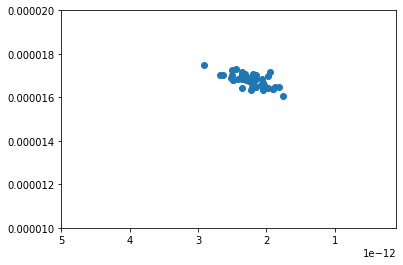

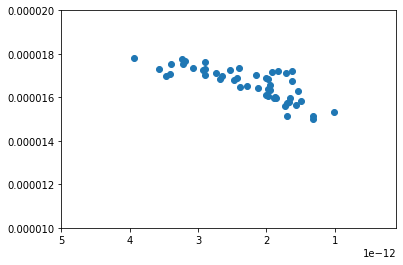

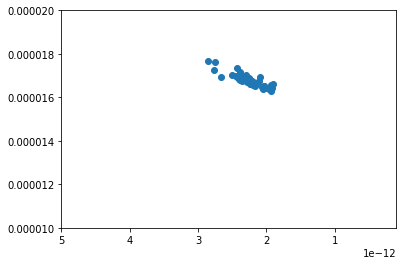

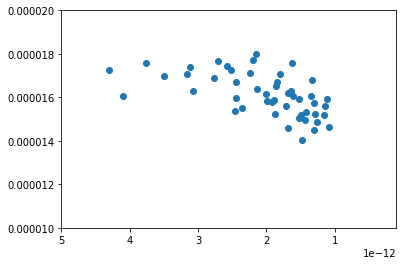

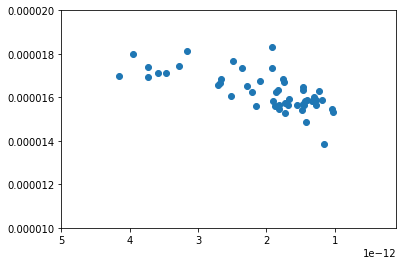

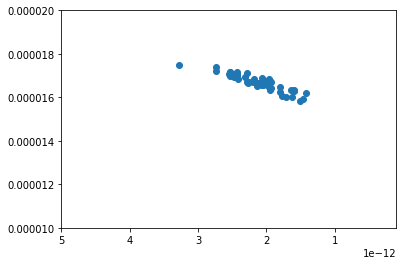

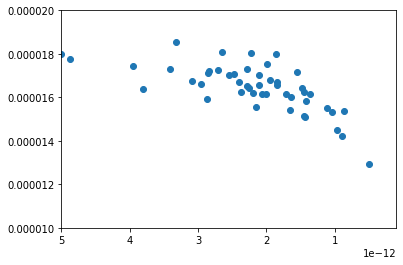

In [485]:
factor = sample_num // 50
for idx in range(15):
    start = 50 * idx
    end = 50 * (idx+1)

    plt.scatter(total_result[start*factor:end*factor,0],total_result[start*factor:end*factor,2])
    plt.xlim(5e-12, 1e-13) # Ioff
    plt.ylim(1e-5, 2e-5)    # Idlin
    plt.show()

In [456]:
# import utils

class EvaluatorFactory():
    
    def __init__(self):
        pass
    
    @staticmethod
    def get_evaluator(sample_num, testType='gan'):
        if testType == 'gan':
            return gan_evaluator(sample_num)
        elif testType == 'vae':
            return vae_evaluator(sample_num)
        elif testType == 'gaussian':
            return gaussian_evaluator(sample_num)
        
class gan_evaluator():
    
    def __init__(self, sample_num):
        
        self.sample_num = sample_num
        self.prob = {}
        
    def train_eval(self, generator, discriminator, val_loader, noise_d):
        
        p_real, p_fake = 0., 0.
        batch_num = 0
        
        generator.eval()
        discriminator.eval()
        
        for i, data in enumerate(val_loader):
            print(i)
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            
            mini_batch_size = len(data_x)
            
            z = sample_z(mini_batch_size, noise_d)
            # utils.sample_z
            
            with torch.autograd.no_grad():
                p_real += torch.sum(discriminator(data_y, data_x)/mini_batch_size)
                
                gen_y = generator(z, data_x)
                
                p_fake += torch.sum(discriminator(gen_y, data_x)/mini_batch_size)
                
            batch_num += 1
            
        p_real /= batch_num
        p_fake /= batch_num
        
        self.prob['p_real_val'].append(p_real)
        self.prob['p_fake_val'].append(p_fake)
        
        return p_real, p_fake
        
    def mean_sample(self, mean_model, train_mean, train_std, test_iterator):
        
        mean_result = []
        total = 0

        mean_model.eval()
        
        for i, data in enumerate(test_iterator):
            print(i)
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            print(data_x)
            
            mini_batch_size = len(data_x)
            print(mini_batch_size)
            
            with torch.autograd.no_grad():
                mean = mean_model(data_x)
                
                mean = mean.data.cpu().numpy()
                
                
                mean = mean*train_std + train_mean
                mean_result.append(mean[0].tolist())
                
                total += mini_batch_size
        
        mean_result = np.array(mean_result)
            
        print("mean_result size: ", mean_result.shape)

        return mean_result, total
              
    def noise_sample(self, mean_result, generator, train_mean, train_std, test_loader, num_of_input, num_of_output, noise_d):
        
        noise_result = []
        total = 0
        
        generator.eval()
        
        for i, data in enumerate(test_loader):
            
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            
            mini_batch_size = len(data_x)
            
            with torch.autograd.no_grad():
                
                data_x_sample = data_x.repeat(1, self.sample_num).view(-1, num_of_input)
                              
                # print("batch * sample_num: (expected)", mini_batch_size*self.sample_num, "(result)", data_x_sample.shape)
                
                z = sample_z(mini_batch_size*self.sample_num, noise_d)
                noise = generator(z, data_x_sample)
                
                noise = noise.data.cpu().numpy()
                
                noise = noise*train_std + train_mean
                print(noise.shape)
                
                noise_result.append(noise.tolist())
                
                total += mini_batch_size
            
        
        noise_result = np.array(noise_result)
        noise_result = noise_result.reshape(-1, num_of_output)
        
        print("noise_result_size: ", noise_result.shape)
        
        return noise_result, total

In [251]:
f = torch.FloatTensor([[1,2,3],[4,5,6],[7,8,9]])
g = np.array([])
print(g.vstack([3,5,6]))

c= f.repeat(1, 3)

# view(-1,3)
print(c)

AttributeError: 'numpy.ndarray' object has no attribute 'vstack'

In [435]:
import torch
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np

import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.metrics import r2_score
import os

def get_dataset(name, datatype):
    if name == 'LER_data_20191125.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=8, num_in_cycle=10, num_of_cycle=270, num_train=230, num_val=20, num_test=20, x_cols="D:G", y_cols="K:S", header=2)
    elif name == 'LER_data_20191107.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=8, num_in_cycle=10, num_of_cycle=185, num_train=150, num_val=15 , num_test=20, x_cols="D:G", y_cols="K:S", header=2)
    elif name == '2020_LER_20200529_V004.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=6, num_in_cycle=50, num_of_cycle=72, num_train=50, num_val=10, num_test=12, x_cols="D:G", y_cols="H:P", header=0)
    elif name == '2020_LER_20200804_V006.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=6, num_in_cycle=50, num_of_cycle=200, num_train=150, num_val=20, num_test=30, x_cols="B:G", y_cols="H:P", header=0)
        
def load_data(file_path, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header):  
    """
    
     1) 20191107 기준 : num_input, num_output, num_of_cycle = 185, num_in_cycle=10, header=2, usecols="D:G" 확인 필수
     2) num_input, num_output, num_in_cycle, num_of_cycle 새로 추가함
    
    """
    num_total = num_of_cycle*num_in_cycle
    
    if datatype == 'none':
        data_x = pd.read_excel('./'+file_path, sheet_name='uniformly sampled',usecols=x_cols, nrows=num_total+1, header=header)
        data_y = pd.read_excel('./'+file_path, sheet_name='uniformly sampled', usecols=y_cols, nrows=num_total+1, header=header)
        
        # No one-hot encoding 
        X_all , Y_all = np.zeros((num_total, num_input)), np.zeros((num_total, num_output))
        X_per_cycle, Y_per_cycle = np.zeros((num_of_cycle, num_input)), np.zeros((num_of_cycle, num_output))
        
        # PANDAS TO NUMPY
        # X_per_cycle
        for i in range(num_of_cycle):
            X_per_cycle[i] = data_x[i*num_in_cycle+1:i*num_in_cycle+2].values

        # X_all
        X_all = np.repeat(X_per_cycle,num_in_cycle,axis=0)
        for i in range(X_all.shape[0]):
            print(X_all[i])


        # Y_all
        for i in range(num_total):
            Y_all[i] = data_y[i+1:i+2].values

        # Y_per_cycle
        for i in range(num_of_cycle):
            Y_per_cycle[i] = np.mean(Y_all[i*num_in_cycle:(i+1)*num_in_cycle],axis=0)

    else:
        data_x = pd.read_excel('./'+file_path, sheet_name='Generated DATAs',usecols=x_cols, nrows=num_total+1, header=header)
        data_y = pd.read_excel('./'+file_path, sheet_name='Generated DATAs', usecols=y_cols, nrows=num_total+1, header=header)

        # one-hot encoding (num_input +1)
        X_all , Y_all = np.zeros((num_total, num_input+1)), np.zeros((num_total, num_output))
        X_per_cycle, Y_per_cycle = np.zeros((num_of_cycle, num_input+1)), np.zeros((num_of_cycle, num_output))
 
        # DATA_X DATA_Y preprocessing

        # 1. N, P to 10, 01 (one-hot encoding)
        data_x =pd.get_dummies(data_x, columns=['PNMOS'], dtype=float)

        # 2. Remove unrequired column ( Wfin [nm], alpha )
        # X: Wfin, alpha
        data_x = data_x.drop('Wfin [nm]', axis=1)
        data_x = data_x.drop('alpha', axis=1)

        # Y: IDLO, IDHI, DIBL
        data_y = data_y.drop('IDLO', axis=1)
        data_y = data_y.drop('IDHI', axis=1)
        data_y = data_y.drop('DIBL(mV)', axis=1)
        
        # PANDAS TO NUMPY
        # X_per_cycle
        for i in range(num_of_cycle):    
            #print(data_x[i*num_in_cycle:i*num_in_cycle+1])
            X_per_cycle[i] = data_x[i*num_in_cycle:i*num_in_cycle+1].values

        # X_all
        X_all = np.repeat(X_per_cycle,num_in_cycle,axis=0)

        # DATA_Y preprcoessing

        # Y_all
        for i in range(num_total):
            Y_all[i] = data_y[i:i+1].values

        # Y_per_cycle    
        for i in range(num_of_cycle):
            Y_per_cycle[i] = np.mean(Y_all[i*num_in_cycle:(i+1)*num_in_cycle],axis=0)

        
    print("============ Data load =============")
    print("X data shape: ", X_all.shape, "X per cycle data shape:", X_per_cycle.shape)
    print("Y data shape: ", Y_all.shape, "Y per cycle data shape:", Y_per_cycle.shape)  
    print("any nan in X?: ", np.argwhere(np.isnan(X_all)))
    print("any nan in Y?: ", np.argwhere(np.isnan(Y_all)))
      
    return X_all, Y_all, X_per_cycle, Y_per_cycle

def split_data(x, y, num_train, num_val, num_test):
    
    if len(x) == len(y):
        print("Same number of x data and y data")
        len_total = len(x)
    else:
        print("Different number of x data and y data")
    
    x_train, y_train = x[:num_train], y[:num_train]
    x_val, y_val = x[num_train:num_train+num_val], y[num_train:num_train+num_val]
    x_test, y_test = x[num_train+num_val:], y[num_train+num_val:]
    
    print("============= Data split ==============")
    print("train X: {} train Y: {}".format(x_train.shape, y_train.shape))
    print("val X: {} val Y: {}".format(x_val.shape, y_val.shape))
    print("test X: {} test Y: {}".format(x_test.shape, y_test.shape))

    y_train_mean = np.mean(y_train, axis=0, dtype=np.float32)
    y_train_std = np.std(y_train, axis=0, dtype=np.float32)
    
    x_train_mean = np.mean(x_train, axis=0, dtype=np.float32)
    x_train_std = np.std(x_train, axis=0, dtype=np.float32)
    
    print("x mean, std: ", x_train_mean, x_train_std)
    print("y mean, std: ", y_train_mean, y_train_std)
    
    return x_train, y_train, x_val, y_val, x_test, y_test
    

class Dataset():   
    def __init__(self, name):
        
        self.train_X = None
        self.val_X = None
        self.test_X = None        
        
        self.train_Y = None
        self.val_Y = None
        self.test_Y = None
        
        self.train_X_per_cycle = None
        self.val_X_per_cycle = None
        self.test_X_per_cycle = None
              
        self.train_Y_per_cycle = None
        self.val_Y_per_cycle = None
        self.test_Y_per_cycle = None
        
        self.train_Y_mean= None
        self.val_Y_mean = None
        self.test_Y_mean = None
        
        self.train_Y_noise = None
        self.val_Y_noise = None
        self.test_Y_noise = None

class SEMI_data(Dataset):
    def __init__(self, name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, num_train, num_val, num_test, x_cols, y_cols, header):
        super().__init__(name)
        
        # DATASET with no PN type (2019 datas)
     
        if datatype == 'none':
            X_all, Y_all, X_per_cycle, Y_per_cycle = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
        
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle, num_val*num_in_cycle, num_test*num_in_cycle)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train, num_val, num_test) 
            

        # DATASET with PN type (2020 datas)
        
        # use P type
        elif datatype == 'p':
            X_all_temp, Y_all_temp, X_per_cycle_temp, Y_per_cycle_temp = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
            
            X_all = np.empty(num_input+1)
            Y_all= np.empty(num_output)
            
            for i in range(num_of_cycle):
                X_all = np.vstack((X_all, X_all_temp[num_in_cycle*(2*i+1):num_in_cycle*(2*i+1)+num_in_cycle]))
                X_per_cycle = X_per_cycle_temp[1::2]
                Y_all = np.vstack((Y_all, Y_all_temp[num_in_cycle*(2*i+1):num_in_cycle*(2*i+1)+num_in_cycle]))
                Y_per_cycle = Y_per_cycle_temp[1::2]
                
            X_all = X_all[1:]
            Y_all = Y_all[1:]
        
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle//2, num_val*num_in_cycle//2, num_test*num_in_cycle//2)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train//2, num_val//2, num_test//2) 
            
        # use N type
        elif datatype == 'n': 
            X_all_temp, Y_all_temp, X_per_cycle_temp, Y_per_cycle_temp = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
            
            X_all = np.empty(num_input+1)
            Y_all= np.empty(num_output)
            
            for i in range(num_of_cycle):
                X_all = np.vstack((X_all, X_all_temp[num_in_cycle*(2*i):num_in_cycle*(2*i)+num_in_cycle]))
                X_per_cycle = X_per_cycle_temp[::2]
                Y_all = np.vstack((Y_all, Y_all_temp[num_in_cycle*(2*i):num_in_cycle*(2*i)+num_in_cycle]))
                Y_per_cycle = Y_per_cycle_temp[::2]
            
            X_all = X_all[1:]
            Y_all = Y_all[1:]                                       

            # print(X_all.shape, Y_all.shape, X_per_cycle.shape, Y_per_cycle.shape)
            
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle//2, num_val*num_in_cycle//2, num_test*num_in_cycle//2)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train//2, num_val//2, num_test//2)        
        # use both P, N type
        else:
            
            X_all, Y_all, X_per_cycle, Y_per_cycle = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)

            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle, num_val*num_in_cycle, num_test*num_in_cycle)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train, num_val, num_test)             
        
        # STEP 2: Split data
        
        # OPTIONAL: Split data for Y_mean, Y_noise
        
        self.train_Y_mean = np.repeat(self.train_Y_per_cycle, num_in_cycle, axis=0)
        self.val_Y_mean = np.repeat(self.val_Y_per_cycle, num_in_cycle, axis=0)
        self.test_Y_mean = np.repeat(self.test_Y_per_cycle, num_in_cycle, axis=0)
        
        print("train_Y_mean shape", self.train_Y_mean.shape)
        print("val_Y_mean shape", self.val_Y_mean.shape)
        print("test_Y_mean shape", self.test_Y_mean.shape)
        
        self.train_Y_noise = self.train_Y - self.train_Y_mean
        self.val_Y_noise = self.val_Y - self.val_Y_mean
        self.test_Y_noise = self.test_Y - self.test_Y_mean
        
        print("train_Y_noise shape", self.train_Y_noise.shape)
        print("val_Y_noise shape", self.val_Y_noise.shape)
        print("test_Y_noise shape", self.test_Y_noise.shape) 

In [395]:
# UTILS

def normalize(x, y):
        
    x_mean = np.mean(x, axis=0, dtype=np.float32)
    x_std = np.std(x, axis=0, dtype=np.float32)
        
    y_mean = np.mean(y, axis=0, dtype=np.float32)
    y_std = np.std(y, axis=0, dtype=np.float32)
        
    norm_x = ( x - x_mean ) / x_std
    norm_y = ( y - y_mean )  / y_std
        
    print(x_mean, x_std)
    print(y_mean, y_std)
    
    return norm_x, norm_y, y_mean, y_std

def init_params(model):
    for p in model.parameters():
        if (p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

In [490]:
import torch
import torch.utils.data as td

class SemiLoader(td.Dataset):
    def __init__(self, data_x, data_y, normalize = None):
        
        self.data_x = data_x
        self.data_y = data_y
        
        if normalize is not None:
            temp_data_x, self.data_y, self.data_y_mean, self.data_y_std = normalize(data_x[:,:3], data_y)    
            self.data_x[:,:3] = temp_data_x
            print(self.data_x)

            
    def __len__(self):
        return len(self.data_x)
           
    def __getitem__(self, index):
            
        x = self.data_x[index]
        y = self.data_y[index]
            
        x = torch.from_numpy(x).float().cuda()
        y = torch.from_numpy(y).float().cuda()
                
        #x[3] = 1.0
        #x[4] = 0.0
        
        # print(x, y)
        return x, y
    

In [61]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn.modules.utils import _single, _pair, _triple

def get_mean_model(mean_model_type, mean_hidden_dim, num_of_input, num_of_output, datatype):
    
    # 'N/P type -> one-hot' increases num of input
    if datatype == 'n' or datatype == 'p':
        num_of_input += 1
    elif datatype == 'none':
        pass
    else:
        num_of_input += 2
    
    if mean_model_type == 'mlp':
        return mean_mlp_net(mean_hidden_dim=mean_hidden_dim, num_of_input=num_of_input, num_of_output=num_of_output)
    
class mean_mlp_net(nn.Module):
    def __init__(self, mean_hidden_dim, num_of_input, num_of_output):
        super(mean_mlp_net, self).__init__()
        self.fc1 = nn.Linear(num_of_input, mean_hidden_dim)
        self.fc2 = nn.Linear(mean_hidden_dim, mean_hidden_dim)
        self.fc3 = nn.Linear(mean_hidden_dim, mean_hidden_dim)
        self.fc4 = nn.Linear(mean_hidden_dim, num_of_output)
        
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        #x=F.dropout(x, training=self.training)
        x=self.fc4(x)
        return x    
    
def get_gan_model(gan_type, gan_hidden_dim, noise_d, num_of_input, num_of_output, datatype):

    # 'N/P type -> one-hot' increases num of input    
    if datatype == 'n' or datatype == 'p':
        num_of_input += 1
    elif datatype == 'none':
        pass 
    else:
        num_of_input += 2
        
    if gan_type == 'gan1':
        return gen1(noise_d+num_of_input, gan_hidden_dim, num_of_output), dis1(num_of_output+num_of_input, gan_hidden_dim)
    
class gen1(nn.Module):
    def __init__(self, d_noise_num_of_input, gan_hidden_dim, num_of_output):
        super(gen1, self).__init__()
        self.fc1 = nn.Linear(d_noise_num_of_input, gan_hidden_dim)
        self.fc2 = nn.Linear(gan_hidden_dim, gan_hidden_dim)
        self.fc3 = nn.Linear(gan_hidden_dim, num_of_output)
        
    def forward(self, noise, x):
        gen_input = torch.cat((noise, x), axis=1)
        r = F.relu(self.fc1(gen_input))
        r = F.relu(self.fc2(r))
        r = self.fc3(r)
        
        return r
        
class dis1(nn.Module):
    def __init__(self, num_of_output, gan_hidden_dim):
        super(dis1, self).__init__()
        self.fc1 = nn.Linear(num_of_output, gan_hidden_dim)
        self.fc2 = nn.Linear(gan_hidden_dim, gan_hidden_dim)
        self.fc3 = nn.Linear(gan_hidden_dim, 1)
        
    def forward(self, y, x):
        dis_input = torch.cat((y, x), axis=1)
        r = F.relu(self.fc1(dis_input))
        r = F.relu(self.fc2(r))
        r = torch.sigmoid(self.fc3(r))
        
        return r

In [22]:
# utils

def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)

In [492]:
def get_mean_trainer(train_iterator, val_iterator, mean_model, mean_model_type, optimizer, exp_lr_scheduler):
    if mean_model_type == 'mlp':
        return mean_trainer(train_iterator, val_iterator, mean_model, optimizer, exp_lr_scheduler)
    
def get_gan_trainer(noise_trainer_iterator, noise_val_iterator, gan_model_type, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d):
    if gan_model_type == 'gan1':
        return gan1_trainer(noise_trainer_iterator, noise_val_iterator, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d)

class mean_GenericTrainer:
    """
    Base class for mean trainer
    """
    def __init__(self, train_iterator, val_iterator, mean_model, optimizer, exp_lr_scheduler):
        self.train_iterator = train_iterator
        self.val_iterator = val_iterator
        self.model = mean_model
                
        self.optimizer = optimizer
        self.current_lr = None
        
        self.exp_lr_scheduler = exp_lr_scheduler
        
        self.loss = {'train_loss':[], 'val_loss':[]}
    
class mean_trainer(mean_GenericTrainer):
    def __init__(self, train_iterator, val_iterator, mean_model, optimizer, exp_lr_scheduler):
        super().__init__(train_iterator, val_iterator, mean_model, optimizer, exp_lr_scheduler)
            
        self.best_loss = np.inf
        self.best_model = None
            
    def train(self):
        
        train_loss_list = []
        train_loss = 0
        train_num = 0
        self.model.train()
        
        for i, data in enumerate(self.train_iterator):
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            
            mini_batch_size = len(data_x)
            output = self.model(data_x)
            loss = F.mse_loss(output, data_y, reduction='mean')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss
            train_num += mini_batch_size
            
        train_loss /= train_num
        self.loss['train_loss'].append(train_loss)
            
        for param_group in self.optimizer.param_groups:
            self.current_lr = param_group['lr']
        self.exp_lr_scheduler.step()
        
        return train_loss
            
    def evaluate(self):

        val_loss_list = []
        val_loss = 0.0
        val_num = 0
        self.model.eval()
        
        true_arr = []
        pred_arr = []
        
        with torch.no_grad():
            for i, data in enumerate(self.val_iterator):
                data_x, data_y = data
                data_x, data_y = data_x.cuda(), data_y.cuda()
                
                mini_batch_size = len(data_x)
                
                output = self.model(data_x)
                loss = F.mse_loss(output, data_y, reduction='mean')
                
                val_loss += loss
                val_num += len(data_y)
                
                true_arr += (data_y.data.cpu().numpy()).tolist()
                pred_arr += (output.data.cpu().numpy()).tolist()
                
            val_loss /= val_num
            self.loss['val_loss'].append(val_loss)
            
        val_r2 = r2_score(true_arr, pred_arr)
        
        if val_loss < self.best_loss:
            self.best_model = self.model
            self.best_loss = val_loss
            self.best_mean = pred_arr
            
                
        return val_loss, val_r2      

class gan_GenericTrainer:
    def __init__(self, noise_trainer_iterator, noise_val_iterator, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d):
        self.train_iterator = noise_trainer_iterator
        self.val_iterator = noise_val_iterator
        
        self.G = generator
        self.D = discriminator
        
        self.optimizer_G = optimizer_g
        self.optimizer_D = optimizer_d
        
        self.exp_gan_lr_scheduler = exp_gan_lr_scheduler
        self.current_d_lr = None
        
        self.noise_d = noise_d
        
        self.prob = {'p_real_train':[], 'p_fake_train':[], 'p_real_val':[], 'p_fake_val':[]}
        
class gan1_trainer(gan_GenericTrainer):
    def __init__(self, noise_trainer_iterator, noise_val_iterator, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d):
        super().__init__(noise_trainer_iterator, noise_val_iterator, generator, discriminator, optimizer_g, optimizer_d, exp_gan_lr_scheduler, noise_d)
                
    def train(self):
        
        self.G.train()
        self.D.train()
        
        for i, data in enumerate(self.train_iterator):
            
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            mini_batch_size = len(data_x)
            
            # GENERATOR
            
            z = sample_z(mini_batch_size, self.noise_d)
            
            gen_y = self.G(z, data_x)
            p_fake = self.D(gen_y, data_x)
            g_loss = -1*torch.log(p_fake).mean()

            self.optimizer_G.zero_grad()
            g_loss.backward()
            self.optimizer_G.step()
            
            # DISCRIMINATOR
            
            # Loss for real data
            p_real = self.D(data_y, data_x)
            d_real_loss = -1*torch.log(p_real).mean()
            # Loss for fake data            
            
            z = sample_z(mini_batch_size, self.noise_d)
            
            gen_y = self.G(z, data_x)
            p_fake = self.D(gen_y, data_x)
            d_fake_loss = -1*torch.log(1.-p_fake).mean()  
    
            d_loss = (d_real_loss + d_fake_loss)/2
        
            self.optimizer_D.zero_grad()
            d_loss.backward()
            self.optimizer_D.step()
            
        # print(p_real)
        self.prob['p_real_train'].append(p_real)
        self.proby['p_real_train'].append(p_real)

        # print(self.prob['p_real_train'])
        self.prob['p_fake_train'].append(p_fake)
        self.proby['p_fake_train'].append(p_fake)
        #print(self.prob['p_real_train'])
        #print(self.prob['p_fake_train'])
            
        for param_group in self.optimizer_D.param_groups:
            self.current_d_lr = param_group['lr']
        self.exp_gan_lr_scheduler.step()
        
        # print("train: ", p_real, p_fake)
        
        return p_real, p_fake
                    
    def evaluate(self):
        
        p_real, p_fake = 0., 0.
        batch_num = 0
        
        self.G.eval()
        self.D.eval()
        
        for i, data in enumerate(self.val_iterator):
            
            data_x, data_y = data
            data_x, data_y = data_x.cuda(), data_y.cuda()
            
            mini_batch_size = len(data_x)
            
            z = sample_z(mini_batch_size, self.noise_d)
            
            with torch.autograd.no_grad():
                p_real += torch.sum(self.D(data_y, data_x)/mini_batch_size)
                
                gen_y = self.G(z, data_x)
                
                p_fake += torch.sum(self.D(gen_y, data_x)/mini_batch_size)
                
            batch_num += 1
            
        p_real /= batch_num
        p_fake /= batch_num
        
        self.prob['p_real_val'].append(p_real)
        self.prob['p_fake_val'].append(p_fake)

        return p_real, p_fake

In [32]:
def sample_z(batch_size = 1, d_noise=100):    # latent dim 크기를 가지는 가우시안 노이즈 벡터를 배치수만큼의 갯수로 추출하는 함수.
    return torch.randn(batch_size, d_noise).cuda()